<a href="https://colab.research.google.com/github/Eshan133/Hate-Speech-Detection/blob/main/RES_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## Importing Packages

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
import torchvision
from tqdm import tqdm
from google.colab import files
from google.colab import drive

## 1. Defining Paths

In [ ]:
# Train Path
no_hate_path = '/content/drive/My Drive/Hate Speech Competition/Subtask A Train/No Hate'
hate_path = '/content/drive/My Drive/Hate Speech Competition/Subtask A Train/Hate'
train_text_path_A = '/content/drive/My Drive/Hate Speech Competition/Train Text/STask_A_train.csv'

# Val Path
val_path_A = '/content/drive/My Drive/Hate Speech Competition/STask_A_val_img'
val_text_path_A = '/content/drive/My Drive/Hate Speech Competition/Eval Data Text/STask-A(index,text)val.csv'
val_path_A_label = '/content/drive/My Drive/Hate Speech Competition/Eval Data Labels/STask-A(index,label)val.csv'

# Test Path
test_path_A = '/content/drive/My Drive/Hate Speech Competition/STask_A_test_img'
test_text_path_A = '/content/drive/My Drive/Hate Speech Competition/STask-A(index,text)test.csv'

----
## 2. Dataset

### 2.1 Defining Images as List

In [ ]:
# List files in No Hate folder
no_hate_files = os.listdir(no_hate_path)
print(f"Number of files in No Hate folder: {len(no_hate_files)}")
print(f"First few files in No Hate: {no_hate_files[:5]}")

print('---------------')

# List files in Hate folder
hate_files = os.listdir(hate_path)
print(f"Number of files in Hate folder: {len(hate_files)}")
print(f"First few files in Hate: {hate_files[:5]}")

print('---------------')

val_files = os.listdir(val_path_A)
print(f"Number of files in VAL folder: {len(val_files)}")
print(f"First few files in VAL: {val_files[:5]}")

print('---------------')

test_files = os.listdir(test_path_A)
print(f"Number of files in VAL folder: {len(test_files)}")
print(f"First few files in VAL: {test_files[:5]}")

Number of files in No Hate folder: 2065
First few files in No Hate: ['5780.png', '5781.png', '5786.png', '5792.png', '5797.png']
---------------
Number of files in Hate folder: 1985
First few files in Hate: ['5324.png', '5325.png', '5326.png', '5327.png', '5337.png']
---------------
Number of files in VAL folder: 506
First few files in VAL: ['9404.png', '9426.png', '9478.png', '1863.png', '9469.png']
---------------
Number of files in VAL folder: 507
First few files in VAL: ['9444.png', '9370.png', '9331.png', '9348.png', '9486.png']


### 2.2 Converting that list into Dataframe

In [ ]:
import pandas as pd

# Collect file paths and labels
train_data = []
val_data = []
test_data = []

for file in no_hate_files:
    train_data.append([os.path.join(no_hate_path, file),file, 0])  # 0 for No Hate
for file in hate_files:
    train_data.append([os.path.join(hate_path, file),file, 1])  # 1 for Hate
for file in val_files:
    val_data.append([os.path.join(val_path_A, file),file])
for file in test_files:
    test_data.append([os.path.join(test_path_A, file),file])


# Create a DataFrame
train_img_df = pd.DataFrame(train_data, columns=['image_path','index','label'])
train_text_df = pd.read_csv(train_text_path_A)

val_img_df = pd.DataFrame(val_data, columns=['image_path','index'])
val_text_df = pd.read_csv(val_text_path_A)
val_label_df = pd.read_csv(val_path_A_label)

test_img_df = pd.DataFrame(test_data, columns=['image_path','index'])
test_text_df = pd.read_csv(test_text_path_A)

### 2.3 Merging training dataframe (`img_df`, `text_df`)

In [ ]:
print(f"Shape of train_img_df: {train_img_df.shape}")
print(f"Shape of train_text_df: {train_text_df.shape}")

Shape of train_img_df: (4050, 3)
Shape of train_text_df: (4050, 3)


In [ ]:
merged_train_df = pd.merge(train_img_df, train_text_df, on='index', how='left', suffixes=('', '_drop'))

merged_train_df = merged_train_df.loc[:, ~merged_train_df.columns.str.endswith('_drop')]

In [ ]:
merged_train_df.head()

,image_path,index,label,text
0,/content/drive/My Drive/Hate Speech Competitio...,5780.png,0,the holy trinity gay cannibals mads minelles m...
1,/content/drive/My Drive/Hate Speech Competitio...,5781.png,0,recruiting people to be gay recruiting people ...
2,/content/drive/My Drive/Hate Speech Competitio...,5786.png,0,me after making a post that says upvote if gay...
3,/content/drive/My Drive/Hate Speech Competitio...,5792.png,0,that's the girl who thinks is a trans allegory...
4,/content/drive/My Drive/Hate Speech Competitio...,5797.png,0,when people talk about gay rights trans rights...


In [ ]:
merged_train_df.shape

(4050, 4)


### 2.4 Merging validation dataframe (`img_df`, `text_df`, `label_df`)


In [ ]:
print(f"Shape of val_img_df: {val_img_df.shape}")
print(f"Shape of val_text_df: {val_text_df.shape}")
print(f"Shape of val_label_df: {val_label_df.shape}")

Shape of val_img_df: (506, 2)
Shape of val_text_df: (506, 2)
Shape of val_label_df: (506, 2)


In [ ]:
merged_df = pd.merge(val_img_df, val_text_df, on='index', how='left', suffixes=('', '_drop'))

merged_df = pd.merge(merged_df, val_label_df, on='index', how='left', suffixes=('', '_drop'))

merged_val_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_drop')]

In [ ]:
merged_val_df.head()

,image_path,index,text,label
0,/content/drive/My Drive/Hate Speech Competitio...,9404.png,a gop senator is stalling a bill to let pregna...,1
1,/content/drive/My Drive/Hate Speech Competitio...,9426.png,ph trans rights are human rights ze oho,0
2,/content/drive/My Drive/Hate Speech Competitio...,9478.png,fight bigotry 98 of straight men are unwilling...,0
3,/content/drive/My Drive/Hate Speech Competitio...,1863.png,me living happily as a cis man relatable trans...,0
4,/content/drive/My Drive/Hate Speech Competitio...,9469.png,woan there partner round these here parts we s...,0


In [ ]:
merged_val_df.shape

(506, 4)


### 2.5 Merging test dataframe (`img_df`, `text_df`)


In [ ]:
print(f"Shape of test_img_df: {test_img_df.shape}")
print(f"Shape of test_text_df: {test_text_df.shape}")

Shape of test_img_df: (507, 2)
Shape of test_text_df: (507, 2)


In [ ]:
merged_test_df = pd.merge(test_img_df, test_text_df, on='index', how='left', suffixes=('', '_drop'))

merged_test_df = merged_test_df.loc[:, ~merged_test_df.columns.str.endswith('_drop')]

In [ ]:
merged_test_df.head()

,image_path,index,text
0,/content/drive/My Drive/Hate Speech Competitio...,9444.png,gender graph intersex feminine masculine demig...
1,/content/drive/My Drive/Hate Speech Competitio...,9370.png,oo me enjoying all of the gay content my homop...
2,/content/drive/My Drive/Hate Speech Competitio...,9331.png,female weebs saying they exist male weebs sayi...
3,/content/drive/My Drive/Hate Speech Competitio...,9348.png,men in dresses women in suits nonbinary people...
4,/content/drive/My Drive/Hate Speech Competitio...,9486.png,if lesbians like women ho how come they date g...


In [ ]:
merged_test_df.shape

(507, 3)


### 2.5 Visualize the Input: **IMAGE & TEXT**

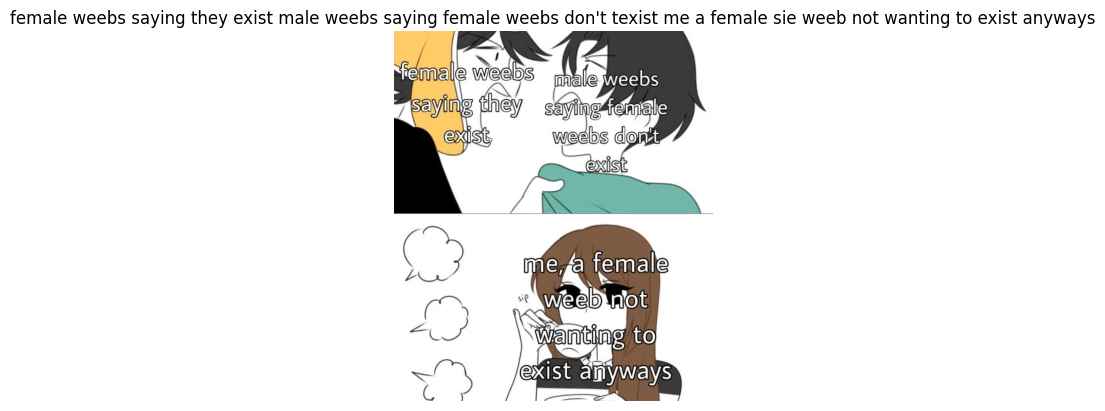

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the first image path from merged_df
first_image_path = merged_test_df['image_path'].iloc[2]

# Load and display the image
img = Image.open(first_image_path)
plt.imshow(img)
plt.title(merged_test_df['text'].iloc[2])
plt.axis('off')
plt.show()

### Dataset Defined & Combined
**Datasets:**
- `merged_val_df`
- `merged_train_df`
- `merged_test_df`

---
## 3. Designing Custom Dataset


### 3.1 Custom Train Multimodel Dataset

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = 128  # Max length for text tokens

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        text = str(self.dataframe.iloc[idx]['text'])
        label = self.dataframe.iloc[idx]['label']

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize text
        encoding = self.tokenizer(text, max_length=self.max_length, padding='max_length',
                                 truncation=True, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return image, input_ids, attention_mask, label

### 3.2 Custom Test Multimodel Datase

In [ ]:
class TestMultimodalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = 128  # Max length for text tokens

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        text = str(self.dataframe.iloc[idx]['text'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)
        index = self.dataframe.iloc[idx]['index']  # Return index (e.g., "9444.png")
        return image, input_ids, attention_mask, index

### 3.2 Defining Transforms & Datasets

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norms
])

In [ ]:
train_dataset = MultimodalDataset(merged_train_df, transform=transform)
val_dataset = MultimodalDataset(merged_val_df, transform=transform)
test_dataset = TestMultimodalDataset(merged_test_df, transform=transform)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### 3.3 Create dataloaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


---
## 4. Defining the Model

### 4.1 MultimodalResNetBERT Model

In [ ]:
class MultimodalResNetBERT(nn.Module):
    def __init__(self, num_classes=2):
        super(MultimodalResNetBERT, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.image_fc = nn.Linear(512, 256)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(768, 256)
        self.fc = nn.Linear(256 * 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Increased dropout for regularization

    def forward(self, images, input_ids, attention_mask):
        image_features = self.resnet(images)
        image_features = self.relu(self.image_fc(image_features))
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output
        text_features = self.relu(self.text_fc(text_features))
        combined_features = torch.cat((image_features, text_features), dim=1)
        combined_features = self.dropout(combined_features)
        output = self.fc(combined_features)
        return output

---
## 5. Initialize model, loss, and optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalResNetBERT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)  # Lower LR and add weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----
## 6. Function to plot training metrics

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import gc

In [ ]:
def plot_training_metrics(train_losses, train_accuracies, train_f1_scores, val_accuracies, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, 'g-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1_scores, 'g-', label='Training F1 Score')
    plt.plot(epochs, val_f1_scores, 'r-', label='Validation F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize scaler for mixed precision training
scaler = GradScaler()

In [ ]:
# Training function with F1 score
def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    all_predictions = []
    all_labels = []
    for images, input_ids, attention_mask, labels in tqdm(train_loader, desc="Training", unit="batch"):
        images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_f1 = f1_score(all_labels, all_predictions, average='binary')
    print(f'Training Loss: {train_loss:.4f}, Training F1 Score: {train_f1:.4f}, Training Accuracy: {train_acc:.2f}%')
    return train_loss, train_f1, train_acc

# Validation function with F1 score
def evaluate_val(model, val_loader, criterion, device):
    model.eval()
    all_predictions = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for images, input_ids, attention_mask, labels in tqdm(val_loader, desc="Validating", unit="batch"):
            images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_labels, all_predictions, average='binary')
    val_acc = 100 * sum([p == l for p, l in zip(all_predictions, all_labels)]) / len(all_labels)
    print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Accuracy: {val_acc:.2f}%')
    return val_loss, val_f1, val_acc

---
## 7. Training and Validaton

In [ ]:
num_epochs = 20
train_losses = []
train_f1_scores = []
train_accuracies = []
val_losses = []
val_f1_scores = []
val_accuracies = []
best_val_f1 = 0.0
patience = 2
trigger_times = 0

for epoch in range(num_epochs):
    # Train
    train_loss, train_f1, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_f1, val_acc = evaluate_val(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.2f}%")
    print("==========================")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_subtask_a.pth')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    scheduler.step(val_loss)
    torch.cuda.empty_cache()
    gc.collect()



Training:   0%|          | 0/254 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-27-1231774094.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [02:37<00:00,  1.61batch/s]


Training Loss: 0.6719, Training F1 Score: 0.5798, Training Accuracy: 58.59%


Validating:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating: 100%|██████████| 32/32 [00:21<00:00,  1.51batch/s]


Validation Loss: 0.6419, Validation F1 Score: 0.4323, Validation Accuracy: 61.07%
Epoch 1: Train Loss: 0.6719, Train F1: 0.5798, Train Acc: 58.59%, Val Loss: 0.6419, Val F1: 0.4323, Val Acc: 61.07%


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-27-1231774094.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [02:36<00:00,  1.62batch/s]


Training Loss: 0.5911, Training F1 Score: 0.6782, Training Accuracy: 69.28%


Validating:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s]


Validation Loss: 0.5555, Validation F1 Score: 0.6816, Validation Accuracy: 71.94%
Epoch 2: Train Loss: 0.5911, Train F1: 0.6782, Train Acc: 69.28%, Val Loss: 0.5555, Val F1: 0.6816, Val Acc: 71.94%


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-27-1231774094.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [02:30<00:00,  1.69batch/s]


Training Loss: 0.4849, Training F1 Score: 0.7779, Training Accuracy: 77.88%


Validating:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating: 100%|██████████| 32/32 [00:20<00:00,  1.58batch/s]


Validation Loss: 0.5108, Validation F1 Score: 0.7621, Validation Accuracy: 75.69%
Epoch 3: Train Loss: 0.4849, Train F1: 0.7779, Train Acc: 77.88%, Val Loss: 0.5108, Val F1: 0.7621, Val Acc: 75.69%


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-27-1231774094.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [02:31<00:00,  1.67batch/s]


Training Loss: 0.3574, Training F1 Score: 0.8532, Training Accuracy: 85.41%


Validating:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating: 100%|██████████| 32/32 [00:18<00:00,  1.71batch/s]


Validation Loss: 0.5493, Validation F1 Score: 0.7454, Validation Accuracy: 75.30%
Epoch 4: Train Loss: 0.3574, Train F1: 0.8532, Train Acc: 85.41%, Val Loss: 0.5493, Val F1: 0.7454, Val Acc: 75.30%


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-27-1231774094.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [02:31<00:00,  1.68batch/s]


Training Loss: 0.2368, Training F1 Score: 0.9139, Training Accuracy: 91.48%


Validating:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating: 100%|██████████| 32/32 [00:18<00:00,  1.68batch/s]

Validation Loss: 0.5963, Validation F1 Score: 0.7400, Validation Accuracy: 75.69%
Epoch 5: Train Loss: 0.2368, Train F1: 0.9139, Train Acc: 91.48%, Val Loss: 0.5963, Val F1: 0.7400, Val Acc: 75.69%
Early stopping triggered!


### 7.1 Plotting training and testing metrics

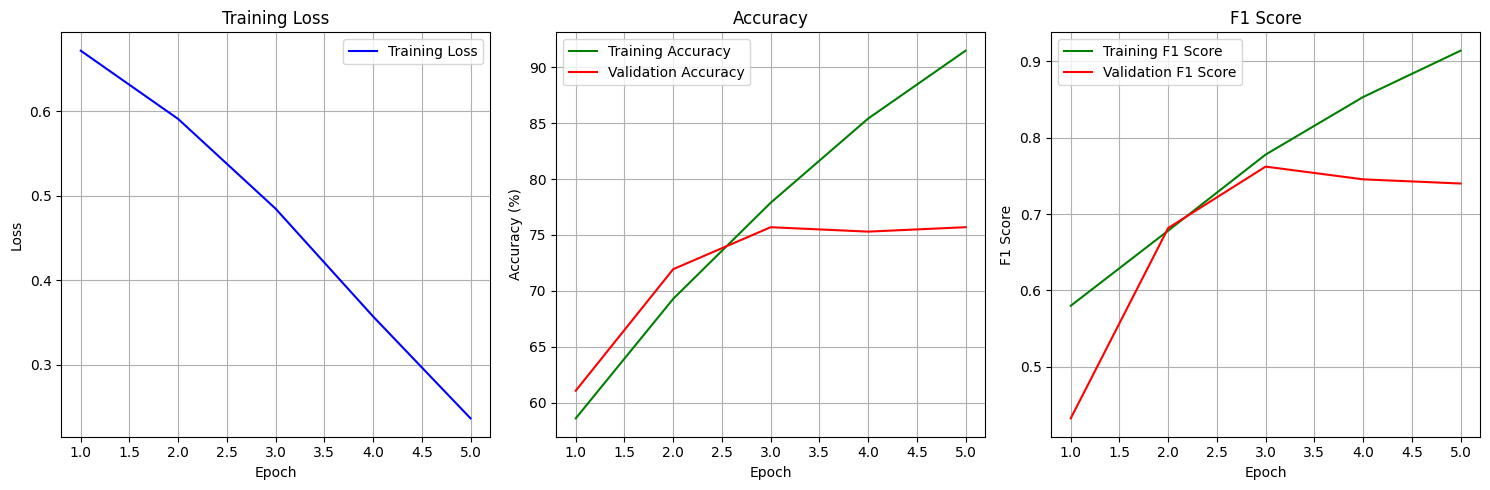

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot metrics
plot_training_metrics(train_losses, train_accuracies, train_f1_scores, val_accuracies, val_f1_scores)

# Save and download the best model
model_save_path = 'multimodal_model_latest.pth'
torch.save(model.state_dict(), model_save_path)
try:
    files.download(model_save_path)
    print(f"Downloading {model_save_path}...")
except ImportError:
    print(f"Model saved to {model_save_path}. Download manually if not in Colab.")

---
## 8. Making prediction

In [ ]:
# Prediction on test set
model.eval()
all_predictions = []
all_indices = []

with torch.no_grad():
    for images, input_ids, attention_mask, indices in tqdm(test_loader, desc="Testing", unit="batch"):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = model(images, input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_indices.extend(indices)

Testing:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 32/32 [01:09<00:00,  2.17s/batch]


In [ ]:
import json

In [ ]:
submission = [{"index": idx, "prediction": int(pred)} for idx, pred in zip(all_indices, all_predictions)]
submission = sorted(submission, key=lambda x: x["index"])
with open("submission.json", "w") as f:
    json.dump(submission, f)
os.system("zip ref.zip submission.json")
files.download("ref.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-----
# CLIP MODEL